In [2]:
import pandas as pd
df = pd.read_csv('../data/raw/battery_failure_surfaces.csv')
print(df.shape)
print(df.columns.tolist())
df.head(10)

(477253, 11)
['cell_chemistry', 'cycle', 'charge_rate_C', 'discharge_rate_C', 'cell_temperature_C', 'internal_resistance_mOhm', 'capacity_retention_%', 'cumulative_high_temp_cycles', 'fast_charge_exposure_cycles', 'irreversible_damage_index', 'thermal_runaway_risk_score']


,cell_chemistry,cycle,charge_rate_C,discharge_rate_C,cell_temperature_C,internal_resistance_mOhm,capacity_retention_%,cumulative_high_temp_cycles,fast_charge_exposure_cycles,irreversible_damage_index,thermal_runaway_risk_score
0,Li-ion NMC,0,1.311626,2.401429,33.544339,33.923862,99.972475,0,0,0.0,0.02
1,Li-ion NMC,1,1.311626,2.401429,33.359694,33.947258,99.944950,0,0,0.0,0.02
2,Li-ion NMC,2,1.311626,2.401429,33.787926,33.970654,99.917425,0,0,0.0,0.02
3,Li-ion NMC,3,1.311626,2.401429,32.878808,33.994050,99.889901,0,0,0.0,0.02
4,Li-ion NMC,4,1.311626,2.401429,32.150625,34.017447,99.862376,0,0,0.0,0.02
5,Li-ion NMC,5,1.311626,2.401429,31.494700,34.040843,99.834851,0,0,0.0,0.02
6,Li-ion NMC,6,1.311626,2.401429,30.655003,34.064239,99.807326,0,0,0.0,0.02
7,Li-ion NMC,7,1.311626,2.401429,28.590487,34.087635,99.779801,0,0,0.0,0.02
8,Li-ion NMC,8,1.311626,2.401429,29.685983,34.111031,99.752276,0,0,0.0,0.02
9,Li-ion NMC,9,1.311626,2.401429,30.510015,34.134427,99.724752,0,0,0.0,0.02


### Row Counts Reveal the Survival Hierarchy

| Chemistry | Total Rows | Avg Cycles/Cell |
|-----------|-----------|-----------------|
| Li-ion NMC | 127,884 | ~320 |
| LFP | 159,338 | ~398 |
| Solid-State | 190,031 | ~475 |

With a max of 500 cycles per cell and 400 cells per chemistry, the raw row counts alone expose the survival hierarchy — Solid-State cells average ~475 cycles vs NMC's ~320, reflecting dramatically different failure rates before we even plot anything.


In [3]:
# How many chemistries and how are cycles distributed?
print(df['cell_chemistry'].value_counts())
print()
print(df.groupby('cell_chemistry')['cycle'].agg(['min', 'max', 'count', 'nunique']))

cell_chemistry
Solid-State    190031
LFP            159338
Li-ion NMC     127884
Name: count, dtype: int64

                min  max   count  nunique
cell_chemistry                           
LFP               0  499  159338      500
Li-ion NMC        0  499  127884      500
Solid-State       0  499  190031      500


### Cell Identification & Trajectory Lengths

Of 1,200 cells, 623 completed all 500 cycles — the remaining 577 failed early, with the shortest trajectory at just 154 cycles.

In [4]:
# Create a cell_id by detecting cycle resets
df['cell_id'] = (df.groupby('cell_chemistry')['cycle'].diff() < 0).cumsum()

# Check trajectory lengths
traj_lengths = df.groupby(['cell_chemistry', 'cell_id'])['cycle'].count()
print(traj_lengths.describe())
print()
print(traj_lengths.value_counts().head(10))

count    1200.000000
mean      397.710833
std       125.001387
min       154.000000
25%       273.750000
50%       500.000000
75%       500.000000
max       500.000000
Name: cycle, dtype: float64

cycle
500    623
184      8
247      6
308      6
198      6
321      6
234      6
193      6
170      6
249      5
Name: count, dtype: int64


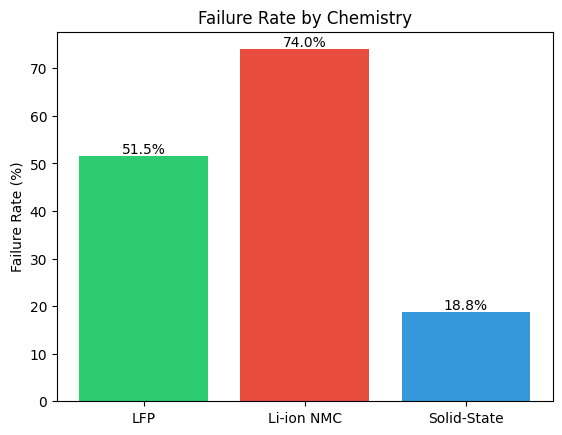

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

COLORS = {
    'Li-ion NMC': '#e74c3c',
    'LFP': '#2ecc71',
    'Solid-State': '#3498db'
}

cell_summary = df.groupby(['cell_chemistry', 'cell_id']).agg(
    cycles_survived=('cycle', 'count'),
    min_capacity=('capacity_retention_%', 'min'),
    max_temp=('cell_temperature_C', 'max'),
    max_damage=('irreversible_damage_index', 'max'),
).reset_index()

cell_summary['failed'] = cell_summary['cycles_survived'] < 500

# Plot 1
failure_rates = cell_summary.groupby('cell_chemistry')['failed'].mean() * 100
bars = plt.bar(failure_rates.index, failure_rates.values,
               color=[COLORS[c] for c in failure_rates.index])
plt.bar_label(bars, fmt='%.1f%%')
plt.ylabel('Failure Rate (%)')
plt.title('Failure Rate by Chemistry')
plt.show()

## Correlation Heatmap

`fast_charge_exposure_cycles`, `irreversible_damage_index`, and `thermal_runaway_risk_score` form a tightly correlated block (0.69–0.99), all strongly negatively correlated with `capacity_retention_%` (-0.82 to -0.86). `cumulative_high_temp_cycles` shows no values — likely constant or empty, needs investigation.

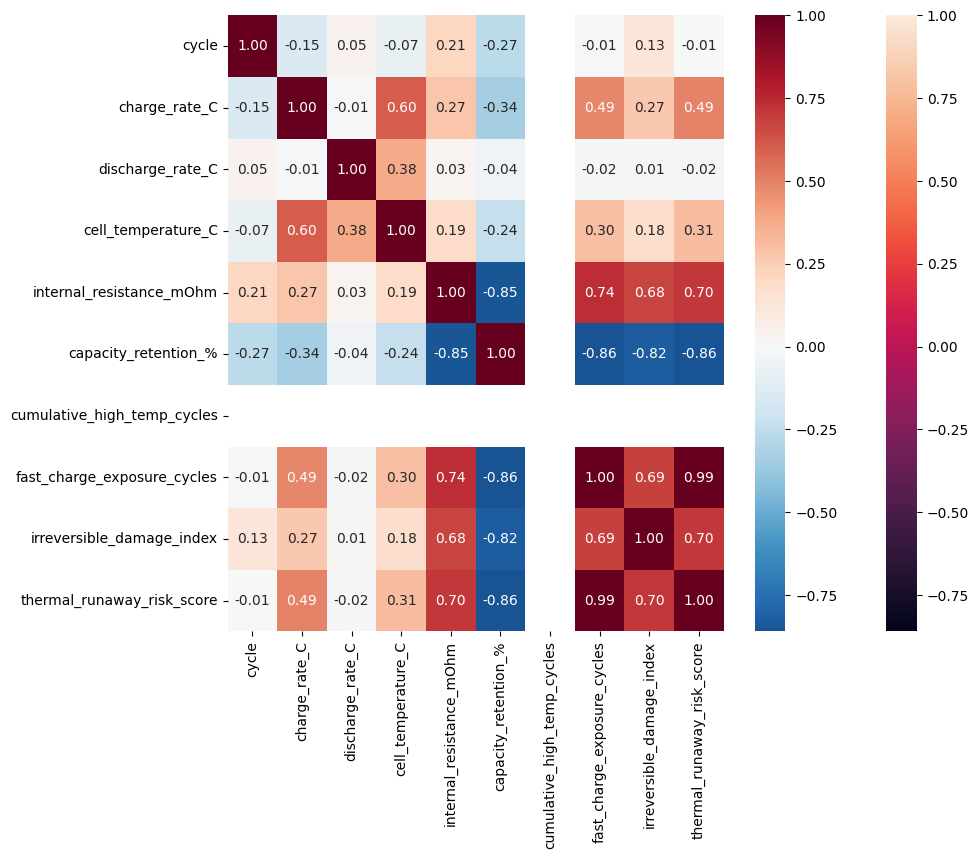

In [6]:
num_features = df.select_dtypes(include='number').drop(columns=['cell_id'])
plt.figure(figsize=(10,8))
sns.heatmap(num_features.corr())
sns.heatmap(num_features.corr(), annot=True, fmt='.2f', cmap='RdBu_r', center=0)
# plt.tight_layout()

plt.show()

`cumulative_high_temp_cycles` is 0 for all records. 

In [7]:
print(df['cumulative_high_temp_cycles'].describe())

count    477253.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: cumulative_high_temp_cycles, dtype: float64


## Capacity Retention vs Irreversible Damage

Capacity holds relatively steady (60–80%) through moderate damage levels, then collapses sharply near damage = 1.0. This nonlinear "cliff" pattern means gradual damage accumulation suddenly becomes catastrophic.

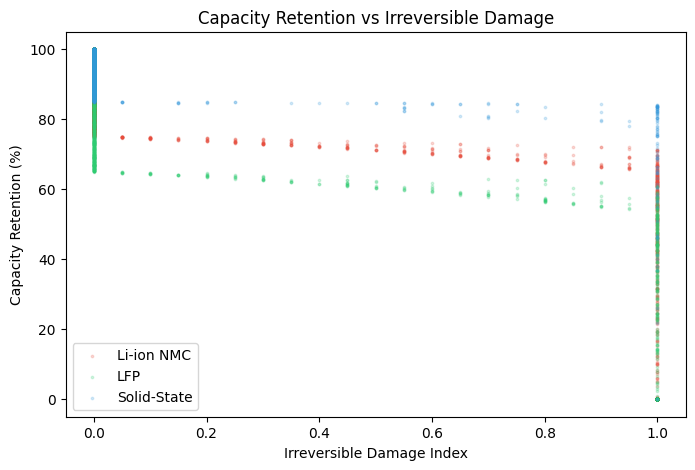

In [8]:
# 1. Capacity retention vs irreversible damage
plt.figure(figsize=(8, 5))
for chem, color in COLORS.items():
    subset = df[df['cell_chemistry'] == chem].sample(5000, random_state=42)
    plt.scatter(subset['irreversible_damage_index'], subset['capacity_retention_%'],
                alpha=0.2, s=3, color=color, label=chem)
plt.xlabel('Irreversible Damage Index')
plt.ylabel('Capacity Retention (%)')
plt.title('Capacity Retention vs Irreversible Damage')
plt.legend()
plt.show()

## Thermal Runaway Risk vs Irreversible Damage

Positive but noisy relationship. NMC and LFP scatter across the full risk range, while Solid-State stays clustered in the low-damage, low-risk corner, consistent with its 18.8% failure rate.

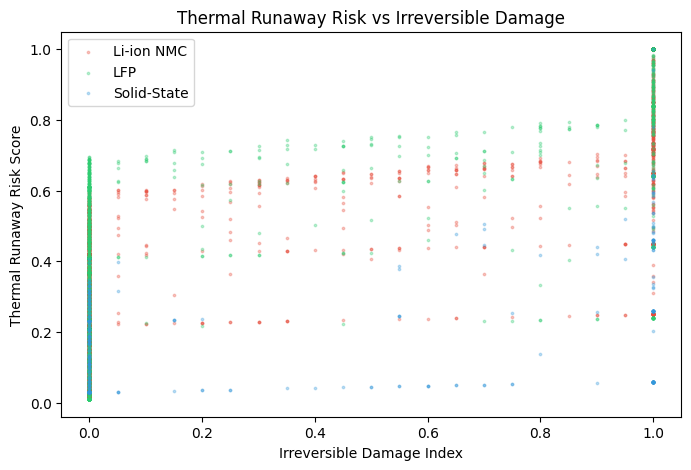

In [9]:
# 2. Thermal runaway risk vs irreversible damage
plt.figure(figsize=(8, 5))
for chem, color in COLORS.items():
    subset = df[df['cell_chemistry'] == chem].sample(5000, random_state=42)
    plt.scatter(subset['irreversible_damage_index'], subset['thermal_runaway_risk_score'],
                alpha=0.3, s=3, color=color, label=chem)
plt.xlabel('Irreversible Damage Index')
plt.ylabel('Thermal Runaway Risk Score')
plt.title('Thermal Runaway Risk vs Irreversible Damage')
plt.legend()
plt.show()

## Fast Charge Exposure & Thermal Runaway Risk Over Cycles

Both plots show a rise-then-drop pattern: NMC peaks around cycle 175, LFP around cycle 225. The drop-off is **survivorship bias**. The high-exposure, high-risk cells are dying and falling out of the average, leaving only the healthier cells behind. **The average decreases not because conditions improve, but because the riskiest cells are gone.**

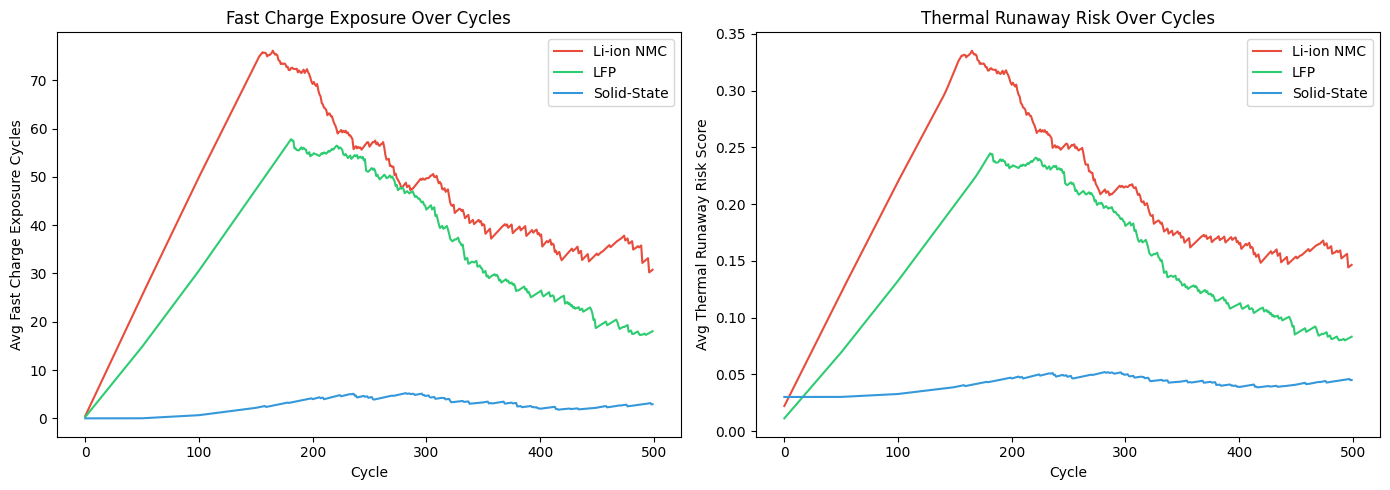

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for chem, color in COLORS.items():
    subset = df[df['cell_chemistry'] == chem]
    avg = subset.groupby('cycle')['fast_charge_exposure_cycles'].mean()
    ax1.plot(avg.index, avg.values, color=color, label=chem)
ax1.set_xlabel('Cycle')
ax1.set_ylabel('Avg Fast Charge Exposure Cycles')
ax1.set_title('Fast Charge Exposure Over Cycles')
ax1.legend()

for chem, color in COLORS.items():
    subset = df[df['cell_chemistry'] == chem]
    avg = subset.groupby('cycle')['thermal_runaway_risk_score'].mean()
    ax2.plot(avg.index, avg.values, color=color, label=chem)
ax2.set_xlabel('Cycle')
ax2.set_ylabel('Avg Thermal Runaway Risk Score')
ax2.set_title('Thermal Runaway Risk Over Cycles')
ax2.legend()

plt.tight_layout()
plt.show()

### EDA Summary

- **1,200 cells** (400 per chemistry), max 500 cycles each. 623 survived, 577 failed.
- **Solid-State dominates**: lowest failure rate (18.8%), highest avg lifespan (~475 cycles), minimal damage accumulation.
- **Li-ion NMC is the weakest**: 74% failure rate, avg ~320 cycles, fastest degradation.
- **Capacity collapse is nonlinear**: cells hold 60–80% capacity through moderate damage, then drop sharply near damage = 1.0.
- **Survivorship bias** in time-series averages: fast charge exposure and thermal runaway risk appear to decrease after cycle ~175, but this is because the riskiest cells are dying and dropping out.
- **Highly correlated feature block**: fast_charge_exposure, irreversible_damage, and thermal_runaway_risk (0.69–0.99). `cumulative_high_temp_cycles` is constant — will drop.
- **Baseline MAE**: [fill in after running] — this is the floor the LSTM must beat.

### Baseline Model — Lag-1 Predictor

The simplest reasonable prediction for next-cycle capacity is "same as this cycle." This lag-1 baseline is surprisingly strong because capacity changes gradually cycle to cycle.

| Prediction Slice | MAE | RMSE |
|-----------------|-----|------|
| All predictions | 0.086% | 0.179% |
| Top 75% worst | 0.110% | 0.207% |
| Top 50% worst | 0.154% | 0.253% |
| Top 25% worst | 0.276% | 0.356% |

The baseline performs well overall but degrades sharply in the tail — the worst 25% of predictions have 3x the error of the average. These are the fast-degrading cells approaching failure, where the "no change" assumption breaks down. This is the gap more sophisticated models need to close: predicting stable cells is easy, catching the ones about to fail is the real challenge.

In [11]:
baseline = df.groupby(["cell_chemistry","cell_id"]).apply(
    lambda g: g['capacity_retention_%'].values[:-1] - g['capacity_retention_%'].values[1:]
).explode().astype(float)

print(f"Baseline MAE: {baseline.abs().mean():.4f}%")
print(f"Baseline RMSE: {(baseline ** 2).mean() ** 0.5:.4f}%")

Baseline MAE: 0.0856%
Baseline RMSE: 0.1790%


In [12]:
errors = baseline.abs()
threshold = errors.quantile(0.75)
tail_errors = errors[errors >= threshold]

print(f"Top 25% worst errors — MAE: {tail_errors.mean():.4f}%")
print(f"Top 25% worst errors — RMSE: {(tail_errors ** 2).mean() ** 0.5:.4f}%")

Top 25% worst errors — MAE: 0.2761%
Top 25% worst errors — RMSE: 0.3557%


In [13]:
errors = baseline.abs()
threshold = errors.quantile(0.5)
tail_errors = errors[errors >= threshold]

print(f"Top 50% worst errors — MAE: {tail_errors.mean():.4f}%")
print(f"Top 50% worst errors — RMSE: {(tail_errors ** 2).mean() ** 0.5:.4f}%")

Top 50% worst errors — MAE: 0.1537%
Top 50% worst errors — RMSE: 0.2525%


In [14]:
errors = baseline.abs()
threshold = errors.quantile(0.25)
tail_errors = errors[errors >= threshold]

print(f"Top 75% worst errors — MAE: {tail_errors.mean():.4f}%")
print(f"Top 75% worst errors — RMSE: {(tail_errors ** 2).mean() ** 0.5:.4f}%")

Top 75% worst errors — MAE: 0.1096%
Top 75% worst errors — RMSE: 0.2066%
